In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, sampler, random_split

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile

# Path to the .tgz file on Google Drive
tgz_path = '/content/drive/MyDrive/datasets/CUB_200_2011.tgz'

# Open the .tgz file
tar = tarfile.open(tgz_path, 'r:gz')

# Extract the contents of the .tgz file (optional)
tar.extractall()
tar.close()


In [ ]:
import tarfile

# Path to the .tgz file on Google Drive
tgz_path = '/content/drive/MyDrive/datasets/segmentations.tgz'

# Open the .tgz file
tar = tarfile.open(tgz_path, 'r:gz')

# Extract the contents of the .tgz file (optional)
tar.extractall()
tar.close()


In [ ]:
def get_data_loaders(data_dir, batch_size):
  transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
  all_data = datasets.ImageFolder(data_dir, transform=transform)
  train_data_len = int(len(all_data)*0.75)
  valid_data_len = int((len(all_data) - train_data_len)/2)
  test_data_len = int(len(all_data) - train_data_len - valid_data_len)
  train_data, val_data, test_data = random_split(all_data, [train_data_len, valid_data_len, test_data_len])
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  return ((train_loader, val_loader, test_loader),train_data, val_data, test_data, all_data.classes)

In [ ]:
(train_loader, val_loader, test_loader),train_data, val_data, test_data, classes = get_data_loaders("CUB_200_2011/images/", 64)

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [ ]:
def plot_images(images, labels, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = labels[i]
        ax.set_title(label)
        ax.axis('off')

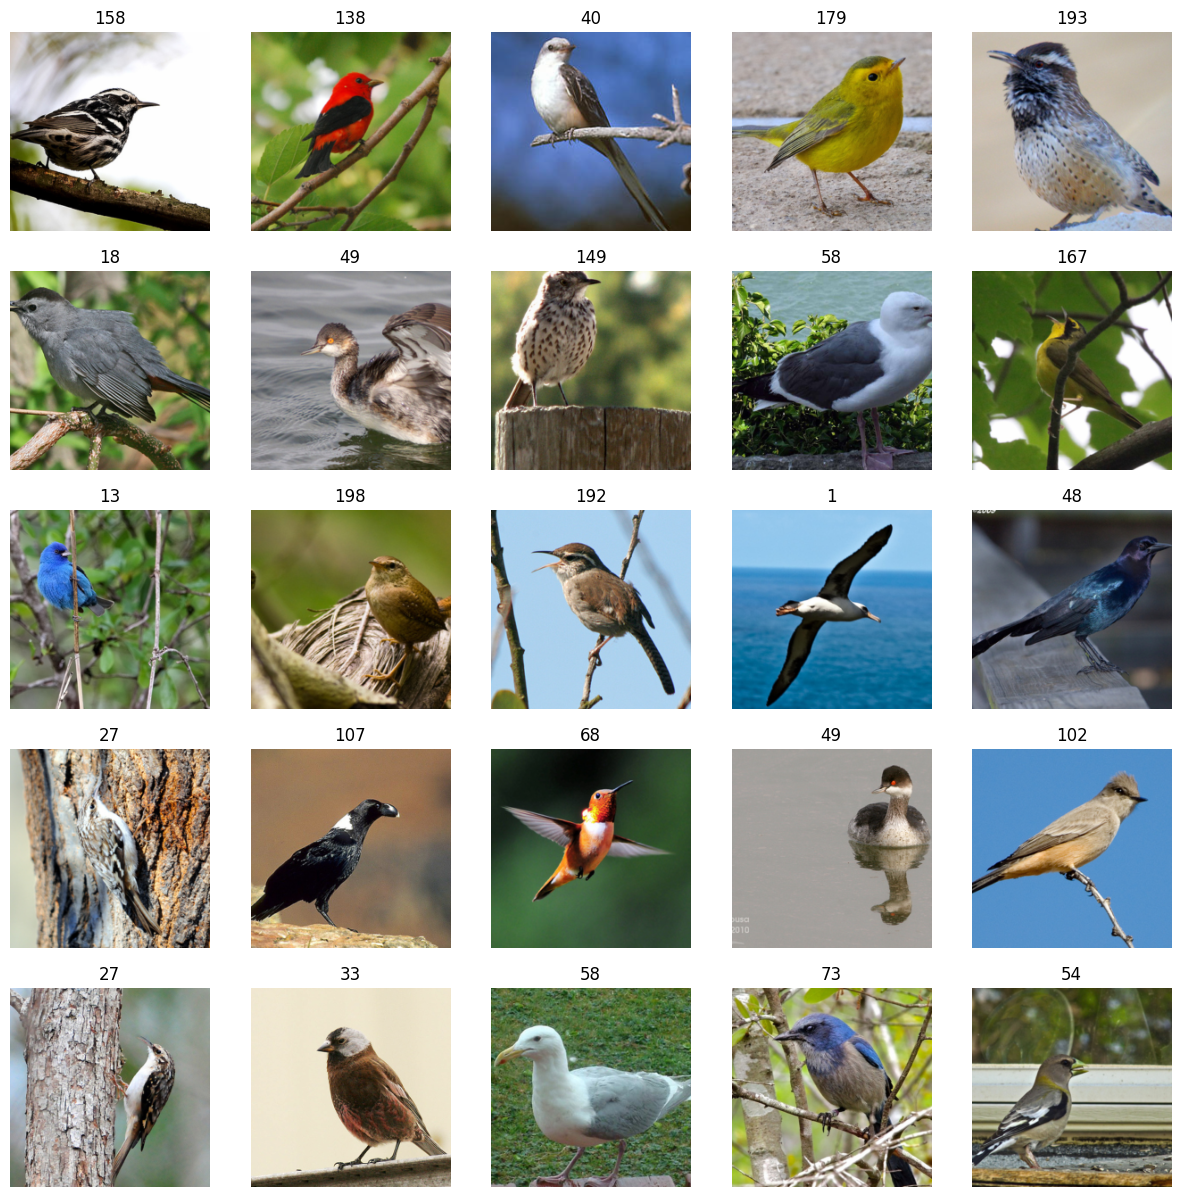

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                           [train_data[i] for i in range(N_IMAGES)]])
plot_images(images, labels)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the CNN model
model = models.resnet18(pretrained=True)
num_classes = len(classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # Apply weight decay

# Function to calculate accuracy
def get_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    accuracy = correct / target.size(0)
    return accuracy

# Training loop
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

best_val_loss = float('inf')  # Track the best validation loss
best_model = None  # Store the best model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_accuracy += get_accuracy(outputs, labels) * images.size(0)
    train_loss /= len(train_data)
    train_accuracy /= len(train_data)

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_accuracy += get_accuracy(outputs, labels) * images.size(0)
        val_loss /= len(val_data)
        val_accuracy /= len(val_data)

    # Check if the current model has the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

# Load the best model
model.load_state_dict(best_model)

# Evaluation on test set
model.eval()
test_loss = 0.0
test_accuracy = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        test_accuracy += get_accuracy(outputs, labels) * images.size(0)
    test_loss /= len(test_data)
    test_accuracy /= len(test_data)

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


Epoch [1/25] - Train Loss: 3.3900 - Train Accuracy: 0.2277 - Val Loss: 2.9850 - Val Accuracy: 0.2559
Epoch [2/25] - Train Loss: 1.7262 - Train Accuracy: 0.5278 - Val Loss: 2.2329 - Val Accuracy: 0.4277
Epoch [3/25] - Train Loss: 1.0622 - Train Accuracy: 0.7008 - Val Loss: 2.7301 - Val Accuracy: 0.3585
Epoch [4/25] - Train Loss: 0.6329 - Train Accuracy: 0.8193 - Val Loss: 1.8391 - Val Accuracy: 0.5255


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import tarfile

# Extract the contents of the segmentation .tgz file
tgz_path = '/content/drive/MyDrive/datasets/segmentations.tgz'
tar = tarfile.open(tgz_path, 'r:gz')
tar.extractall()
tar.close()

# Extract the contents of the CUB_200_2011 .tgz file
tgz_path = '/content/drive/MyDrive/datasets/CUB_200_2011.tgz'
tar = tarfile.open(tgz_path, 'r:gz')
tar.extractall()
tar.close()

# Define data transformations and augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create dataset and data loaders
train_data = ImageFolder("CUB_200_2011/images/", transform=train_transform)
val_data = ImageFolder("CUB_200_2011/images/", transform=val_transform)
test_data = ImageFolder("CUB_200_2011/images/", transform=val_transform)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Define the CNN model
class ResNetEnsemble(nn.Module):
    def __init__(self, num_classes):
        super(ResNetEnsemble, self).__init__()
        self.model1 = models.resnet18(pretrained=True)
        self.model1.fc = nn.Linear(self.model1.fc.in_features, num_classes)
        self.model2 = models.resnet18(pretrained=True)
        self.model2.fc = nn.Linear(self.model2.fc.in_features, num_classes)
        self.model3 = models.resnet18(pretrained=True)
        self.model3.fc = nn.Linear(self.model3.fc.in_features, num_classes)

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)
        return (out1 + out2 + out3) / 3  # Ensemble predictions

num_classes = len(train_data.classes)

# Create the ensemble model
model = ResNetEnsemble(num_classes)

# Enable batch normalization
model = nn.Sequential(nn.BatchNorm2d(3), model)  # Apply batch normalization to input

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def get_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    accuracy = correct / target.size(0)
    return accuracy

# Training loop
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_accuracy += get_accuracy(outputs, labels) * images.size(0)
    train_loss /= len(train_data)
    train_accuracy /= len(train_data)

    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_accuracy += get_accuracy(outputs, labels) * images.size(0)
        val_loss /= len(val_data)
        val_accuracy /= len(val_data)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

# Evaluation on test set
model.eval()
test_loss = 0.0
test_accuracy = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        test_accuracy += get_accuracy(outputs, labels) * images.size(0)
    test_loss /= len(test_data)
    test_accuracy /= len(test_data)

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")
